In [16]:
import numpy as np
import os,keras
from keras.preprocessing import image     
from keras.callbacks import ModelCheckpoint ,Callback,EarlyStopping
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
from keras.utils import plot_model

import keras.backend as K
from keras.models import *

from keras.layers import Convolution2D,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,LSTM,SimpleRNN,GRU,Activation,Lambda,BatchNormalization
from keras.models import Model
from keras.layers.core import Reshape
from keras.layers.wrappers import Bidirectional,TimeDistributed
from keras.regularizers import l2
import csv
import pandas as pd
from keras.optimizers import *
from keras.callbacks import *

In [17]:
chars = '+-*=0123456789()_'

#字符库中的字符数
n_class=len(chars)

#定义Label的最大长度
label_len=15

#图片长度，宽度
image_width = 300
image_height = 64

### 辅助函数

In [18]:
def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(image_height, image_width))
    # 将PIL.Image.Image类型转化为格式为(300, 64, 3)的3维张量
    x = image.img_to_array(img).transpose(1,0,2)
    return np.expand_dims(x, axis=0)

In [19]:
def get_label_y(label):
    new_label = label + ''.join(['_']*(label_len - len(label)))
    y = [chars.find(c) for c in new_label]
    return y

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 模型定义

In [20]:
input_tensor = Input((image_width, image_height, 3))
x = input_tensor

for i in range(3):
    x = Convolution2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Convolution2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(128,(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Convolution2D(128,(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(1, 2))(x)
    
conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2] * conv_shape[3])))(x)

x = Bidirectional(GRU(units=256, return_sequences=True))(x)
x = Bidirectional(GRU(units=256, return_sequences=True))(x)

x = Dropout(0.25)(x)

x = Dense(n_class,activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[label_len], dtype='uint8')
input_length = Input(name='input_length', shape=[1], dtype='uint8')
label_length = Input(name='label_length', shape=[1], dtype='uint8')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 64, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 300, 64, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 300, 64, 32)  128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 300, 64, 32)  9248        batch_normalization_9[0][0]      
__________________________________________________________________________________________________
batch_norm

### 数据生成器

In [21]:
csv_data = pd.read_csv('train.csv')
n_train = 90000
n_valid = 9000
n_test = 1000

def gen(datatype='train',batch_size = 128):
    datalimit = []

    if(datatype=='train'):
        datalimit = [0,n_train-1]
    elif(datatype=='valid'):
        datalimit = [n_train,n_train+n_valid-1]
    elif(datatype=='test'):
        datalimit = [100000 - n_test,99999]
    else:
        raise Exception("datatype must be train,valid or test")
        
    X = np.zeros((batch_size, image_width, image_height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, label_len), dtype=np.uint8)
    label_length = np.zeros(batch_size，dtype=np.uint8)
    i = datalimit[0]-1
    while True:
        for j in range(0,batch_size):
            i = i+1 if i<datalimit[1]-1 else datalimit[0]
            X[j] = path_to_tensor(csv_data['filename'][i])
            y[j] = get_label_y(csv_data['label'][i])
            label_length[j] = len(csv_data['label'][i])
        
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]), label_length], np.ones(batch_size)

### 检测生成器

X_test shape: (10, 300, 64, 3)
y_test shape: (10, 15)
input_lens shape: (10,)
label_lens shape: (10,)
y_true shape: (10,)

label length:9.0


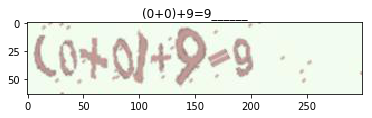

In [25]:
g = gen('train',10)
[X_test, y_test, input_lens, label_lens], y_true  = next(g)

print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))
print('input_lens shape: ' + str(input_lens.shape))
print('label_lens shape: ' + str(label_lens.shape))
print('y_true shape: ' + str(label_lens.shape))

plt.imshow(X_test[0].transpose(1,0,2))
plt.title(''.join([chars[x] for x in y_test[0]]))
print('\nlabel length:' + str(label_lens[0]))

- X_test<br> 
图像数据，形如：(samples,300,64,3)<br>
- y_test<br>
图像真实对应的label字符串转码后的数组，形如：(samples,15)。转码逻辑是将label中字符转成字符在字符集chars中的下标值，y_test我们定义的最大长度是15，由于真实label是变长，不足15位的我们补充了特殊字符'_'  ,被转码后对应到数字16<br>
- input_lens<br>
这个长度是由RNN输出的seq长度，在我们的模型中是37。<br>
- label_lens<br>
这个是每个label的真实长度，在我们的项目中，label是变长的。<br>
- y_true<br>
这个是数据生成器随便给的值，计算loss时不会用到


In [23]:
def evaluate(model, batch_num=1):
    count_acc = 0
    generator = gen('test',100)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = model.predict(X_test)
        shape = y_pred.shape
        ctc_decode = K.ctc_decode(y_pred,input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)
       
        for j in range(y_test.shape[0]):
            y_out = ''.join([chars[x] for x in out[j]]).replace('_','')
            y_true = ''.join([chars[x] for x in y_test[j]]).replace('_','')
            if(y_out==y_true):
                count_acc += 1
    return count_acc / (batch_num*100)

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model,10)*100
        self.accs.append(acc)
        print('\n--------')
        print('acc: %f%%'%acc)

evaluator = Evaluate()

In [ ]:
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

batch_size = 128
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
hist = model.fit_generator(gen('train',batch_size), steps_per_epoch=n_train//batch_size, epochs=50,
                    callbacks=[EarlyStopping(patience=10), evaluator,checkpointer,ReduceLROnPlateau('loss')],
                    validation_data=gen('valid',batch_size),validation_steps=n_valid//batch_size,verbose=1)

model.load_weights("model.hdf5")

Epoch 1/50
703/703 [==============================] - 215s 306ms/step - loss: 3.3716 - val_loss: 2.7601

--------
acc: 80.000000%

Epoch 00001: val_loss improved from inf to 2.76013, saving model to model.hdf5
Epoch 2/50
703/703 [==============================] - 210s 298ms/step - loss: 1.0532 - val_loss: 1.4080

--------
acc: 90.100000%

Epoch 00002: val_loss improved from 2.76013 to 1.40801, saving model to model.hdf5
Epoch 3/50
703/703 [==============================] - 209s 297ms/step - loss: 0.7306 - val_loss: 1.4441

--------
acc: 90.800000%

Epoch 00003: val_loss did not improve from 1.40801
Epoch 4/50
703/703 [==============================] - 209s 297ms/step - loss: 0.6353 - val_loss: 1.2341

--------
acc: 95.500000%

Epoch 00004: val_loss improved from 1.40801 to 1.23414, saving model to model.hdf5
Epoch 5/50
336/703 [=============>................] - ETA: 1:43 - loss: 0.5594

In [ ]:
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()

    plt.tight_layout()
    
training_vis(hist)

## 测试模型

In [43]:
g = gen('test',1)

In [79]:
[X_test, y_test, _, _], _  = next(g)
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1])[0][0])

out = ''.join([chars[x] for x in out[0]])
y_true = ''.join([chars[x] for x in y_test[0]]).replace('_','')

print(out==y_true)
print('pred:' + str(out) + '\ntrue:' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
print(argmax)
print(y_test[0])

True
pred:6+(2-3)=5
true:6+(2-3)=5
[10  0 14  6  1  7 15  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3 16 16 16  9]
[10  0 14  6  1  7 15  3  9 16 16 16 16 16 16]
